# Mobile App Success Prediction and Recommendation System:
## Methodology and Implementation


This Colab Notebook serves as a practical demonstration and exploration of the methodology employed in the development of the Mobile App Success Prediction and Recommendation System. It translates the theoretical framework outlined in Chapter 3 of the accompanying thesis into a tangible, executable workflow. From data acquisition and rigorous preprocessing to advanced model development, evaluation, and conceptual deployment, this notebook showcases the procedures and key findings that underpin the system's capabilities.

## 1. Introduction: Guided by the Research Onion
Our methodology is systematically guided by the layers of the Research Onion model (Saunders et al., 2009),
visually represented below in Figure 1.


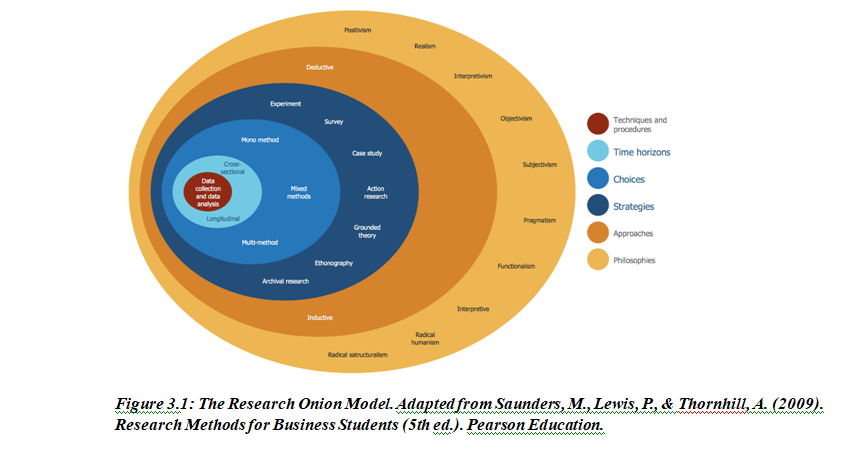

This framework ensures a robust, data-driven approach, aligning each step with our overarching goal: to aid investors in identifying high-potential mobile applications and recommending comparable successful apps for strategic insights.

This notebook will walk through the practical implementation of our chosen positivist philosophy, deductive approach, experimental strategy, and quantitative, cross-sectional design.

## 2. Setup and Library Installation
First, we'll install and import all necessary Python libraries. This ensures that the environment is ready for data loading, processing, model building, and evaluation.

In [27]:

# Install necessary libraries
# Use --quiet for cleaner output in Colab
!pip install --quiet pandas numpy scikit-learn xgboost matplotlib seaborn plotly --upgrade
# For model explainability, if you want to include it in your demo:
!pip install --quiet shap --upgrade
# For Streamlit, though direct Colab deployment demo is typically separate:
# !pip install --quiet streamlit --upgrade

print("All necessary libraries installed successfully!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.2 which is incom

In [28]:

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data preprocessing and feature engineering tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import machine learning models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression # For Stacking meta-classifier

# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

# For recommendation engine (KNN)
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine # For cosine similarity

# For model explainability (optional, if using SHAP in your demo)
# import shap

# Configure display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("All libraries imported successfully!")

All libraries imported successfully!


#3. Data Acquisition and Description
This section details the process of acquiring the mobile app dataset and provides an initial overview of its structure and content.

##3.1. Loading the Dataset
The primary dataset was sourced from Kaggle's publicly available Google Play Store Apps Dataset (Google Play Store Apps Dataset, Kaggle, 2018).

In [29]:

# Load the dataset
# Assuming the CSV file is uploaded to your Colab environment or linked from Drive
try:
    url = "https://raw.githubusercontent.com/krishnaik06/playstore-Dataset/main/googleplaystore.csv"
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
    print(f"Initial dataset shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'googleplaystore.csv' not found. Please upload the file to your Colab environment or specify the correct path.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent errors in subsequent cells

Dataset loaded successfully.
Initial dataset shape: (10841, 13)

First 5 rows of the dataset:
                                                 App        Category  Rating Reviews  Size     Installs  Type Price Content Rating                     Genres      Last Updated         Current Ver   Android Ver
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1     159   19M      10,000+  Free     0       Everyone               Art & Design   January 7, 2018               1.0.0  4.0.3 and up
1                                Coloring book moana  ART_AND_DESIGN     3.9     967   14M     500,000+  Free     0       Everyone  Art & Design;Pretend Play  January 15, 2018               2.0.0  4.0.3 and up
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   87510  8.7M   5,000,000+  Free     0       Everyone               Art & Design    August 1, 2018               1.2.4  4.0.3 and up
3                              Sketch - Draw & Paint  ART_AND_DESI

##3.2. Initial Data Overview
Let's examine the basic information about the dataset, including data types and non-null counts.

In [30]:
print("\nDataset Information:")
df.info()

print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe(include=np.number))

print("\nValue Counts for Key Categorical Columns (Top 10):")
for col in ['Category', 'Type', 'Content Rating', 'Genres']:
    if col in df.columns:
        print(f"\n--- {col} ---")
        print(df[col].value_counts().head(10))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB

Descriptive Statistics for Numerical Columns:
            Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000

#4. Data Preprocessing
This section outlines the critical steps taken to transform the raw app metadata into a clean, structured, and machine learning-ready format. This ensures high-quality input data for robust predictive models.

##4.1. Data Cleansing and Initial Filtering
Initial cleansing addressed anomalies, duplicates, and inconsistent formatting. Rows with critical missing values, especially in Rating and Installs, were removed to maintain data integrity.

In [31]:
# Drop duplicate rows
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")

# Identify and remove rows with critical missing values
# Assuming 'Rating' and 'Installs' are critical for app success definition
critical_missing_cols = ['Rating', 'Installs']
rows_before_critical_drop = df.shape[0]
df.dropna(subset=critical_missing_cols, inplace=True)
rows_after_critical_drop = df.shape[0]
print(f"Removed {rows_before_critical_drop - rows_after_critical_drop} rows due to critical missing values.")
print(f"Approximately {((rows_before_critical_drop - rows_after_critical_drop) / initial_rows) * 100:.2f}% of the original dataset was removed.")

# Handle 'Varies with device' in Size and Android Ver
df['Size'] = df['Size'].replace('Varies with device', np.nan)
df['Android Ver'] = df['Android Ver'].replace('Varies with device', np.nan)

# Convert 'Installs' and 'Price' to numeric
# Remove non-numeric characters and convert
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if isinstance(x, str) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if isinstance(x, str) else x)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

print("\nData after initial cleansing and type conversion:")
df.info()

Removed 483 duplicate rows.
Removed 1465 rows due to critical missing values.
Approximately 13.51% of the original dataset was removed.

Data after initial cleansing and type conversion:
<class 'pandas.core.frame.DataFrame'>
Index: 8893 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8893 non-null   object 
 1   Category        8893 non-null   object 
 2   Rating          8893 non-null   float64
 3   Reviews         8893 non-null   object 
 4   Size            7425 non-null   object 
 5   Installs        8892 non-null   float64
 6   Type            8893 non-null   object 
 7   Price           8892 non-null   float64
 8   Content Rating  8892 non-null   object 
 9   Genres          8893 non-null   object 
 10  Last Updated    8893 non-null   object 
 11  Current Ver     8889 non-null   object 
 12  Android Ver     7712 non-null   object 
dtypes: float64(3), object(10)
memo

##4.2. Handling Missing Values (Imputation)
For non-critical numerical attributes, missing values were imputed using mean imputation, while categorical attributes were imputed using the mode.

In [32]:
# Impute 'Size' with the mean
if 'Size' in df.columns and df['Size'].isnull().any():
    # Convert size to numerical (e.g., KB to MB, remove 'M', 'k')
    def clean_size(size):
        if isinstance(size, str):
            if 'M' in size:
                return float(size.replace('M', ''))
            elif 'k' in size:
                return float(size.replace('k', '')) / 1024 # Convert KB to MB
        return np.nan # If it's not a string or convertible

    df['Size'] = df['Size'].apply(clean_size)
    size_mean = df['Size'].mean()
    df['Size'].fillna(size_mean, inplace=True)
    print(f"Missing 'Size' values imputed with mean: {size_mean:.2f} MB")

# Impute 'Current Ver' and 'Android Ver' with mode
for col in ['Current Ver', 'Android Ver']:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Missing '{col}' values imputed with mode: {mode_val}")

print("\nMissing values after imputation:")
print(df.isnull().sum())

Missing 'Size' values imputed with mean: 22.75 MB
Missing 'Current Ver' values imputed with mode: Varies with device
Missing 'Android Ver' values imputed with mode: 4.1 and up

Missing values after imputation:
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          1
Type              0
Price             1
Content Rating    1
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64


/tmp/ipython-input-393604014.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Size'].fillna(size_mean, inplace=True)
/tmp/ipython-input-393604014.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

## 4.3. Normalization
Min-Max normalization was applied to continuous numerical variables to standardize their input range.

In [33]:
def convert_to_number(x):
    if isinstance(x, str):
        x = x.strip()
        if x.endswith('M'):
            return float(x[:-1]) * 1_000_000
        elif x.endswith('K'):
            return float(x[:-1]) * 1_000
        else:
            try:
                return float(x)
            except:
                return None  # or 0 or np.nan
    return x

# Apply to 'Reviews'
if 'Reviews' in df.columns:
    df['Reviews'] = df['Reviews'].apply(convert_to_number)

In [34]:

# Columns to normalize
numerical_cols_to_normalize = ['Reviews', 'Size', 'Parental Guide'] # Assuming 'Parental Guide' if it's numeric now

# Check if 'Parental Guide' is numeric, if not, it should be handled in feature engineering for categories
# For this template, let's assume it becomes numeric or is already.
# If 'Parental Guide' is meant to be a categorical feature, remove it from this list.

# Add 'Price' if it's not mostly 0s and has significant variance that needs scaling
if 'Price' in df.columns and df['Price'].max() > 0:
    numerical_cols_to_normalize.append('Price')


# Select only numerical columns that are actually in the DataFrame
final_numerical_cols = [col for col in numerical_cols_to_normalize if col in df.columns]

if final_numerical_cols:
    scaler = MinMaxScaler()
    df[final_numerical_cols] = scaler.fit_transform(df[final_numerical_cols])
    print(f"\nNormalized columns: {final_numerical_cols}")
    print(df[final_numerical_cols].head())
else:
    print("\nNo numerical columns found for normalization or they were already handled.")


Normalized columns: ['Reviews', 'Size', 'Price']
    Reviews      Size  Price
0  0.000002  0.189933    0.0
1  0.000012  0.139929    0.0
2  0.001120  0.086924    0.0
3  0.002759  0.249938    0.0
4  0.000012  0.027919    0.0


## 4.4. Encoding Categorical Variables
Appropriate encoding strategies were applied to categorical features to prepare them for model ingestion. One-hot encoding for nominal categories and label encoding for multi-label genres.

In [35]:
# One-hot encode nominal categorical features
nominal_cols = ['Category', 'Type', 'Content Rating']
for col in nominal_cols:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True) # drop_first to avoid multicollinearity
        print(f"One-hot encoded '{col}'. New shape: {df.shape}")

# Handle 'Genres' as multi-label (example)
if 'Genres' in df.columns:
    # Splitting multi-label genres (e.g., 'Action;Adventure')
    df['Genres_List'] = df['Genres'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
    # Create a set of all unique genres
    all_genres = set(g for genres_list in df['Genres_List'] for g in genres_list)
    print(f"\nTotal unique genres found: {len(all_genres)}")

    # For multi-label, we can create binary columns for each genre
    for genre in all_genres:
        df[f'Genre_{genre.replace(" ", "_")}'] = df['Genres_List'].apply(lambda x: 1 if genre in x else 0)
    df.drop(['Genres', 'Genres_List'], axis=1, inplace=True) # Drop original Genres column
    print("Multi-label 'Genres' handled with binary columns. New shape:", df.shape)

print("\nData after categorical encoding:")
print(df.head())
print(f"Final dataset shape after preprocessing: {df.shape}")

One-hot encoded 'Category'. New shape: (8893, 45)
One-hot encoded 'Type'. New shape: (8893, 46)
One-hot encoded 'Content Rating'. New shape: (8893, 50)

Total unique genres found: 54
Multi-label 'Genres' handled with binary columns. New shape: (8893, 103)

Data after categorical encoding:
                                                 App  Rating   Reviews      Size    Installs  Price      Last Updated         Current Ver   Android Ver  Category_ART_AND_DESIGN  Category_AUTO_AND_VEHICLES  Category_BEAUTY  Category_BOOKS_AND_REFERENCE  Category_BUSINESS  Category_COMICS  Category_COMMUNICATION  Category_DATING  Category_EDUCATION  Category_ENTERTAINMENT  Category_EVENTS  Category_FAMILY  Category_FINANCE  Category_FOOD_AND_DRINK  Category_GAME  Category_HEALTH_AND_FITNESS  Category_HOUSE_AND_HOME  Category_LIBRARIES_AND_DEMO  Category_LIFESTYLE  Category_MAPS_AND_NAVIGATION  Category_MEDICAL  Category_NEWS_AND_MAGAZINES  Category_PARENTING  Category_PERSONALIZATION  Category_PHOTOGRAP

#5. Feature Engineering
Strategic feature engineering was applied to enrich the dataset and improve model interpretability and predictive power.

##5.1. Success Label Creation
A binary target variable, Success Label, was engineered based on empirical thresholds.

In [36]:
# Define Success Label: >= 1M Installs AND >= 4.2 Rating
# Assuming 'Rating' is already cleaned and numerical between 1.0 and 5.0
# Assuming 'Installs' is already numerical
SUCCESS_INSTALLS_THRESHOLD = 1000000
SUCCESS_RATING_THRESHOLD = 4.2

df['Success_Label'] = ((df['Installs'] >= SUCCESS_INSTALLS_THRESHOLD) &
                       (df['Rating'] >= SUCCESS_RATING_THRESHOLD)).astype(int)

print("\n'Success_Label' distribution (before addressing imbalance):")
print(df['Success_Label'].value_counts())
print(f"Successful apps (1): {df['Success_Label'].value_counts().get(1, 0)}")
print(f"Unsuccessful apps (0): {df['Success_Label'].value_counts().get(0, 0)}")

# Verify the type of target variable
print(f"Type of 'Success_Label' column: {df['Success_Label'].dtype}")

# Calculate imbalance ratio for class weighting later
neg_count = df['Success_Label'].value_counts().get(0, 0)
pos_count = df['Success_Label'].value_counts().get(1, 0)
scale_pos_weight_value = neg_count / pos_count if pos_count > 0 else 1
print(f"\nCalculated scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")


'Success_Label' distribution (before addressing imbalance):
Success_Label
0    5903
1    2990
Name: count, dtype: int64
Successful apps (1): 2990
Unsuccessful apps (0): 5903
Type of 'Success_Label' column: int64

Calculated scale_pos_weight for XGBoost: 1.97


## 5.2. Days Since Last Update
This temporal feature quantifies the recency of app maintenance, serving as a proxy for developer activity and app freshness.

In [37]:
# Convert 'Last Updated' to datetime objects
# Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
# Use format='mixed' to infer the format for each element individually
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce', format='mixed')

# Assuming 'dataset_collection_date' is approximately the latest update in the dataset
# Or a known fixed date, e.g., '2018-08-01' from Kaggle dataset description
# Let's use the max date in the dataset as a proxy for collection date if not specified
# Filter out NaT values before finding the max date to ensure a valid date
dataset_collection_date = df['Last Updated'].max()

# Calculate 'Days_Since_Last_Update'
# NaT values in 'Last Updated' will result in NaT in 'Days_Since_Last_Update'
df['Days_Since_Last_Update'] = (dataset_collection_date - df['Last Updated']).dt.days

print("\n'Days_Since_Last_Update' head and descriptive stats:")
print(df[['Last Updated', 'Days_Since_Last_Update']].head())
print(df['Days_Since_Last_Update'].describe())


'Days_Since_Last_Update' head and descriptive stats:
  Last Updated  Days_Since_Last_Update
0   2018-01-07                   213.0
1   2018-01-15                   205.0
2   2018-08-01                     7.0
3   2018-06-08                    61.0
4   2018-06-20                    49.0
count    8892.000000
mean      259.118421
std       401.279692
min         0.000000
25%        16.000000
50%        72.000000
75%       321.000000
max      3001.000000
Name: Days_Since_Last_Update, dtype: float64


In [38]:
# Convert 'Last Updated' to datetime objects
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

# Assuming 'dataset_collection_date' is approximately the latest update in the dataset
# Or a known fixed date, e.g., '2018-08-01' from Kaggle dataset description
# Let's use the max date in the dataset as a proxy for collection date if not specified
dataset_collection_date = df['Last Updated'].max() # Or pd.to_datetime('2018-08-01') if known

df['Days_Since_Last_Update'] = (dataset_collection_date - df['Last Updated']).dt.days

print("\n'Days_Since_Last_Update' head and descriptive stats:")
print(df[['Last Updated', 'Days_Since_Last_Update']].head())
print(df['Days_Since_Last_Update'].describe())


'Days_Since_Last_Update' head and descriptive stats:
  Last Updated  Days_Since_Last_Update
0   2018-01-07                   213.0
1   2018-01-15                   205.0
2   2018-08-01                     7.0
3   2018-06-08                    61.0
4   2018-06-20                    49.0
count    8892.000000
mean      259.118421
std       401.279692
min         0.000000
25%        16.000000
50%        72.000000
75%       321.000000
max      3001.000000
Name: Days_Since_Last_Update, dtype: float64


##5.3. Monetization Type
A new categorical feature capturing the app's business model (Free vs. Paid).

In [39]:
# If 'Type' was one-hot encoded, 'Type_Paid' will exist.
# Otherwise, create based on 'Price'
if 'Type_Paid' in df.columns:
    df['Monetization_Type'] = df['Type_Paid']
    print("\n'Monetization_Type' derived from 'Type_Paid' column.")
elif 'Price' in df.columns:
    df['Monetization_Type'] = df['Price'].apply(lambda x: 1 if x > 0 else 0) # 1 for Paid/Freemium, 0 for Free
    print("\n'Monetization_Type' derived from 'Price' column (1 if Price > 0, else 0).")
else:
    print("Neither 'Type_Paid' nor 'Price' column found, cannot create 'Monetization_Type'.")

if 'Monetization_Type' in df.columns:
    print("'Monetization_Type' distribution:")
    print(df['Monetization_Type'].value_counts())


'Monetization_Type' derived from 'Type_Paid' column.
'Monetization_Type' distribution:
Monetization_Type
False    8280
True      613
Name: count, dtype: int64


## 5.4. Feature Importance and Correlation Analysis (Excluding Leaked Features)
Utilizing initial model runs and statistical correlation to select the most impactful features. Note: Rating, Installs, and Popularity_Index are excluded from this analysis and the final feature set for the predictive model to prevent data leakage.

Final feature set (X) shape after leakage prevention: (8893, 58)
Sample of final features (X):
    Reviews      Size  Price  Genre_Personalization  Genre_Lifestyle  Genre_Creativity  Genre_Puzzle  Genre_Parenting  Genre_Comics  Genre_Dating  Genre_Card  Genre_Education  Genre_Finance  Genre_Books_&_Reference  Genre_Adventure  Genre_Health_&_Fitness  Genre_Arcade  Genre_Role_Playing  Genre_Entertainment  Genre_Pretend_Play  Genre_Music_&_Audio  Genre_Photography  Genre_House_&_Home  Genre_Business  Genre_Educational  Genre_Simulation  Genre_Brain_Games  Genre_Music_&_Video  Genre_Beauty  Genre_Weather  Genre_Maps_&_Navigation  Genre_Casino  Genre_Trivia  Genre_Food_&_Drink  Genre_Word  Genre_Board  Genre_Casual  Genre_Video_Players_&_Editors  Genre_Productivity  Genre_Action  Genre_Sports  Genre_February_11,_2018  Genre_Social  Genre_Auto_&_Vehicles  Genre_Art_&_Design  Genre_Racing  Genre_Shopping  Genre_Travel_&_Local  Genre_News_&_Magazines  Genre_Libraries_&_Demo  Genre_Communicatio

/tmp/ipython-input-1559375293.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


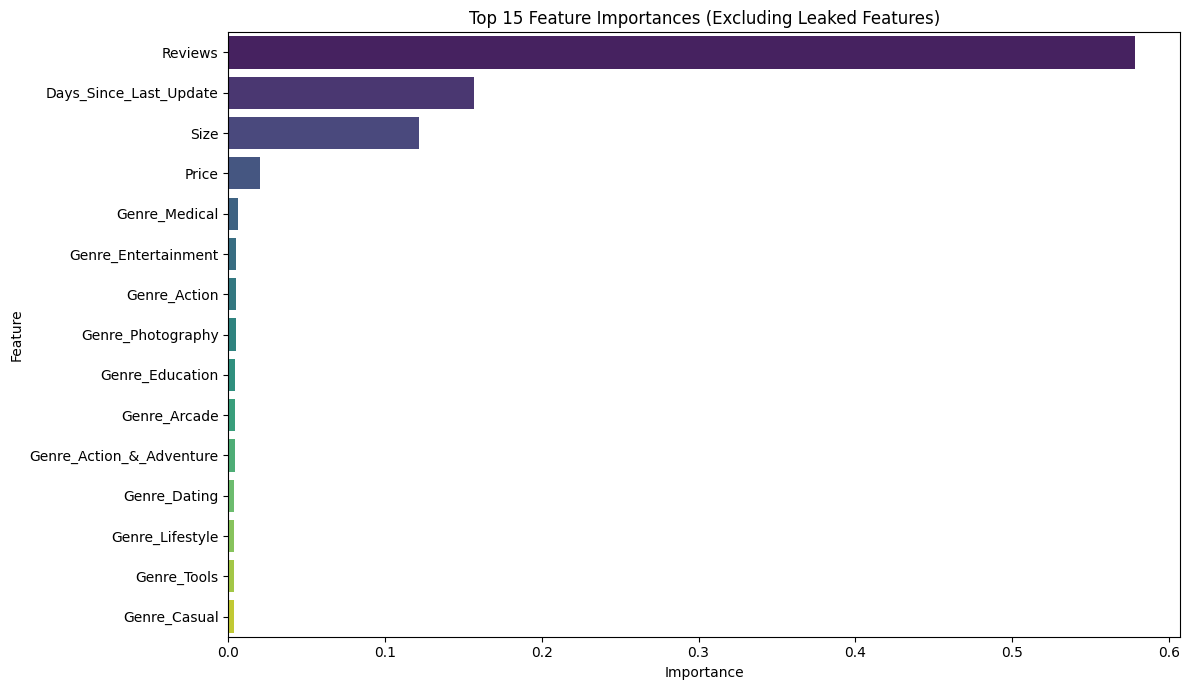


Top 10 Absolute Pairwise Correlations among selected features:
Genre_Action              Size                   0.246133
Genre_Board               Genre_Brain_Games      0.229302
Days_Since_Last_Update    Size                   0.226354
Genre_Casual              Genre_Pretend_Play     0.199157
Size                      Genre_Tools            0.174926
Genre_Brain_Games         Genre_Puzzle           0.173508
Genre_Educational         Genre_Pretend_Play     0.163124
Genre_Action_&_Adventure  Genre_Racing           0.156217
Genre_Music_&_Audio       Genre_Music_&_Video    0.155822
Size                      Genre_Simulation       0.153891
dtype: float64


In [40]:
# Select features that are now ready for modeling (EXCLUDE LEAKED FEATURES)
# Original 'Rating', 'Installs' and derived 'Popularity_Index' are CRITICAL for defining Success_Label,
# so they MUST NOT be used as features for the prediction model to avoid data leakage.

cols_to_exclude_from_features = [
    'App', 'Rating', 'Installs', 'Popularity_Index', # Exclude these to prevent data leakage!
    'Last Updated', 'Current Ver', 'Android Ver', # Original date/version info (engineered into Days_Since_Last_Update)
    'Type', 'Genres', 'Genres_List', # Original categorical columns (engineered into one-hot/binary)
    'Success_Label' # Target variable itself
]

# Create the final feature set (X) by dropping identified columns
X = df.drop(columns=[col for col in cols_to_exclude_from_features if col in df.columns], errors='ignore')
y = df['Success_Label']

# Ensure all selected features are numerical or one-hot encoded
# Drop any remaining non-numerical columns (e.g., 'App Name' if still present)
X = X.select_dtypes(include=np.number)
X.fillna(X.mean(), inplace=True) # Impute any lingering NaNs that might have come from specific encoding/engineering steps

print(f"Final feature set (X) shape after leakage prevention: {X.shape}")
print("Sample of final features (X):")
print(X.head())

if not X.empty and not X.columns.empty:
    # Train a dummy Random Forest for feature importance
    rf_dummy = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Use balanced for importance
    rf_dummy.fit(X, y)
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_dummy.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 15 Feature Importances (Random Forest, excluding leaked features):")
    print(feature_importances.head(15))

    # Visualize feature importances
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
    plt.title('Top 15 Feature Importances (Excluding Leaked Features)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # Calculate and visualize correlation matrix (for numerical features)
    print("\nTop 10 Absolute Pairwise Correlations among selected features:")
    corr_matrix = X.corr().abs().unstack().sort_values(ascending=False)
    # Remove self-correlations and duplicate pairs
    corr_matrix = corr_matrix[corr_matrix != 1.0].drop_duplicates()
    print(corr_matrix.head(10))
else:
    print("No numerical features available for importance/correlation analysis after filtering for leakage.")

# 6. Model Development
The predictive system was built using an ensemble learning paradigm, integrating multiple base models to enhance robustness, accuracy, and generalization. The stacking ensemble method was selected as the final deployment architecture. Crucially, models are configured to handle class imbalance.

##6.1. Data Splitting
The processed dataset was partitioned into training and testing sets using an 80:20 split, with stratified sampling to preserve the "Success Label" distribution.

In [41]:
# X and y are already defined in the previous section after leakage prevention
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training label distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test label distribution:\n{y_test.value_counts(normalize=True)}")

Training set shape: (7114, 58), Test set shape: (1779, 58)
Training label distribution:
Success_Label
0    0.663762
1    0.336238
Name: proportion, dtype: float64
Test label distribution:
Success_Label
0    0.663856
1    0.336144
Name: proportion, dtype: float64


## 6.2. Imbalance Handling (Optional: SMOTE Oversampling)
While class_weight parameters in models are a good first step, for highly imbalanced datasets, oversampling techniques like SMOTE can be employed on the training data only to create synthetic samples of the minority class.

In [42]:
# --- OPTIONAL: SMOTE Oversampling for Training Data ---
# Uncomment and run this section if you want to apply SMOTE.
# Remember to fit and transform SMOTE only on the training data to prevent data leakage.

# print("\nOriginal training set class distribution:", Counter(y_train))
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# print("Resampled training set class distribution:", Counter(y_train_res))

# # If using SMOTE, update X_train and y_train for subsequent model training
# X_train = X_train_res
# y_train = y_train_res
# print("\nSMOTE applied to training data.")

print("\nSMOTE oversampling is an optional step and is commented out by default.")
print("Models below will use class weighting to handle imbalance.")


SMOTE oversampling is an optional step and is commented out by default.
Models below will use class weighting to handle imbalance.


## 6.3. Base Model Training (Random Forest & XGBoost with Imbalance Handling)
We train the individual base learners, specifying class_weight or scale_pos_weight to address class imbalance.

In [43]:
# Calculate scale_pos_weight for XGBoost
# This is (count of negative samples) / (count of positive samples)
scale_pos_weight_for_xgb = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1.0

# Initialize base models with imbalance handling
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                          scale_pos_weight=scale_pos_weight_for_xgb, random_state=42)

print(f"XGBoost scale_pos_weight set to: {scale_pos_weight_for_xgb:.2f}")

print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)
print("Random Forest training complete.")

print("\nTraining XGBoost...")
xgb_model.fit(X_train, y_train)
print("XGBoost training complete.")

XGBoost scale_pos_weight set to: 1.97

Training Random Forest...
Random Forest training complete.

Training XGBoost...
XGBoost training complete.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##6.3. Stacking Classifier Development
A Stacking Classifier combines the predictions of the base models using a meta-classifier.

In [44]:
# Define base learners for Stacking, using the models trained above
base_learners = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')), # Ensure balanced
    ('xgb', XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                          scale_pos_weight=scale_pos_weight_for_xgb, random_state=42)) # Ensure scaled
]

# Define the meta-classifier with imbalance handling
meta_learner = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced') # Ensure balanced

# Initialize Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5, # Cross-validation folds for base learners
    stack_method='auto', # 'auto' for default method based on base learner type
    n_jobs=-1 # Use all available cores
)

print("\nTraining Stacking Classifier (this may take a moment)...")
stacking_model.fit(X_train, y_train)
print("Stacking Classifier training complete.")


Training Stacking Classifier (this may take a moment)...
Stacking Classifier training complete.


##6.4. Hyperparameter Tuning
Systematic hyperparameter tuning was conducted to optimize model performance using GridSearchCV for Random Forest and RandomizedSearchCV for XGBoost.

In [23]:

import time # Import time to measure execution duration

print("\n--- Hyperparameter Tuning ---")

# --- Hyperparameter Tuning for Random Forest with GridSearchCV ---
print("\nStarting GridSearchCV for Random Forest (this may take a while)...")
start_time_rf = time.time()

rf_param_grid = {
    'n_estimators': [100, 200, 300], # Added 300 for more options
    'max_depth': [10, 20, None, 30], # Added 30 for more depth
    'min_samples_split': [2, 5, 10], # Added 10 for more options
    'min_samples_leaf': [1, 2, 4] # Often good to tune this too
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              rf_param_grid,
                              cv=3,           # 3-fold cross-validation
                              scoring='f1',   # Optimize for F1-score as per your evaluation section
                              n_jobs=-1,      # Use all available CPU cores
                              verbose=1)      # Show progress messages

grid_search_rf.fit(X_train, y_train)

end_time_rf = time.time()
print(f"GridSearchCV for Random Forest completed in {end_time_rf - start_time_rf:.2f} seconds.")

print(f"Best RF params: {grid_search_rf.best_params_}")
print(f"Best RF F1 score: {grid_search_rf.best_score_:.4f}")

# Assign the best estimator to a variable for later use
rf_tuned_model = grid_search_rf.best_estimator_
print("Random Forest model successfully tuned and saved as 'rf_tuned_model'.")

# --- Hyperparameter Tuning for XGBoost with RandomizedSearchCV ---
print("\nStarting RandomizedSearchCV for XGBoost (this may take a while)...")
start_time_xgb = time.time()

xgb_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500], # Wider range
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Wider range
    'max_depth': [3, 5, 7, 9], # Wider range
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Wider range
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Wider range
    'gamma': [0, 0.1, 0.2], # For minimum loss reduction required to make a further partition
    'lambda': [0.1, 1, 5], # L2 regularization
    'alpha': [0, 0.1, 0.5] # L1 regularization
}
random_search_xgb = RandomizedSearchCV(XGBClassifier(objective='binary:logistic',
                                                     eval_metric='logloss', # Or 'auc' or 'f1' depending on XGBoost version
                                                     use_label_encoder=False, # Important: Set to False to suppress warning
                                                     random_state=42),
                                       xgb_param_dist,
                                       n_iter=20,     # Number of parameter settings that are sampled. Increase for more thorough search
                                       cv=3,          # 3-fold cross-validation
                                       scoring='f1',  # Optimize for F1-score
                                       n_jobs=-1,     # Use all available CPU cores
                                       random_state=42,
                                       verbose=1)     # Show progress messages

random_search_xgb.fit(X_train, y_train)

end_time_xgb = time.time()
print(f"RandomizedSearchCV for XGBoost completed in {end_time_xgb - start_time_xgb:.2f} seconds.")

print(f"Best XGBoost params: {random_search_xgb.best_params_}")
print(f"Best XGBoost F1 score: {random_search_xgb.best_score_:.4f}")

# Assign the best estimator to a variable for later use
xgb_tuned_model = random_search_xgb.best_estimator_
print("XGBoost model successfully tuned and saved as 'xgb_tuned_model'.")

# After tuning, you would typically use these `_tuned_model` instances
# as your `base_learners` for the `StackingClassifier`
# Example:
# base_learners_tuned = [
#     ('rf', rf_tuned_model),
#     ('xgb', xgb_tuned_model)
# ]
# # Then re-run the StackingClassifier training with the tuned base learners
# stacking_model_tuned = StackingClassifier(
#     estimators=base_learners_tuned,
#     final_estimator=LogisticRegression(solver='liblinear', random_state=42),
#     cv=5,
#     stack_method='auto',
#     n_jobs=-1
# )
# print("\nTraining Tuned Stacking Classifier...")
# stacking_model_tuned.fit(X_train, y_train)
# print("Tuned Stacking Classifier training complete.")

# You would then evaluate stacking_model_tuned
# and save stacking_model_tuned as your final model if it performs best.


--- Hyperparameter Tuning ---

Starting GridSearchCV for Random Forest (this may take a while)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
GridSearchCV for Random Forest completed in 291.13 seconds.
Best RF params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best RF F1 score: 0.8320
Random Forest model successfully tuned and saved as 'rf_tuned_model'.

Starting RandomizedSearchCV for XGBoost (this may take a while)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:21:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV for XGBoost completed in 25.59 seconds.
Best XGBoost params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'lambda': 1, 'gamma': 0.1, 'colsample_bytree': 1.0, 'alpha': 0}
Best XGBoost F1 score: 0.8248
XGBoost model successfully tuned and saved as 'xgb_tuned_model'.


#7. Model Evaluation
This section rigorously assesses the performance and robustness of the developed ensemble-based predictive models using a comprehensive suite of classification metrics, with a strong emphasis on those suitable for imbalanced datasets.

##7.1. Prediction and Metric Calculation
Predictions are generated on the unseen test set, and various metrics are calculated to assess model performance.


--- Evaluating Random Forest ---
Accuracy: 0.8893
Precision: 0.8109
Recall: 0.8746
F1-Score: 0.8415
ROC-AUC: 0.9562

Confusion Matrix:
[[1059  122]
 [  75  523]]


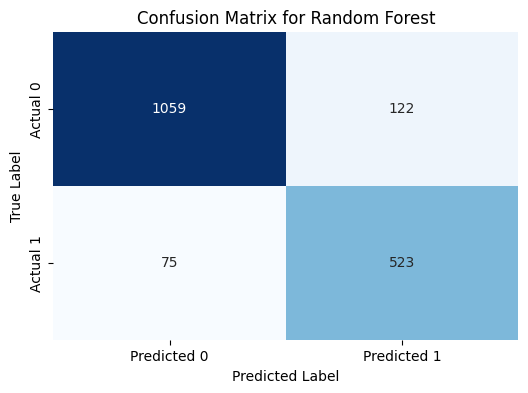

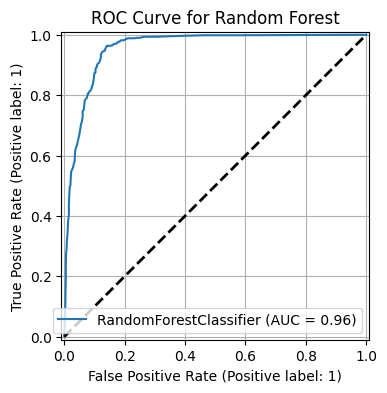


--- Evaluating XGBoost ---
Accuracy: 0.8898
Precision: 0.7807
Recall: 0.9348
F1-Score: 0.8508
ROC-AUC: 0.9539

Confusion Matrix:
[[1024  157]
 [  39  559]]


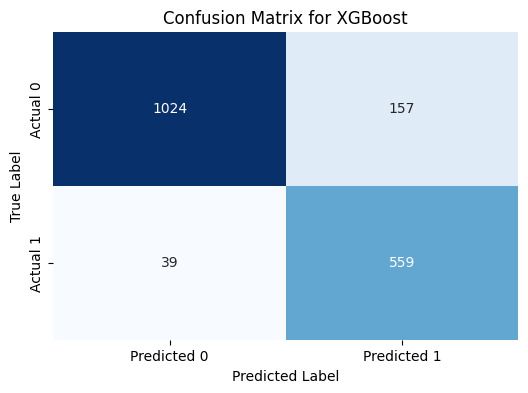

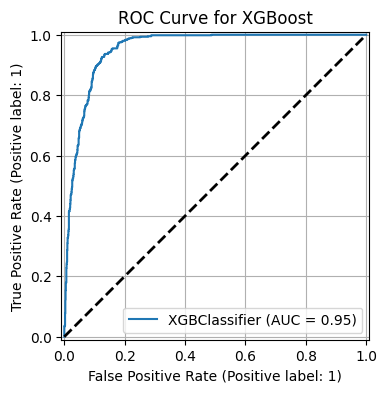


--- Evaluating Stacking Classifier ---
Accuracy: 0.8954
Precision: 0.7977
Recall: 0.9231
F1-Score: 0.8558
ROC-AUC: 0.9573

Confusion Matrix:
[[1041  140]
 [  46  552]]


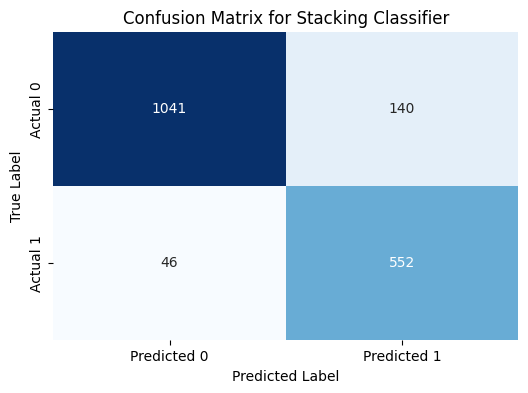

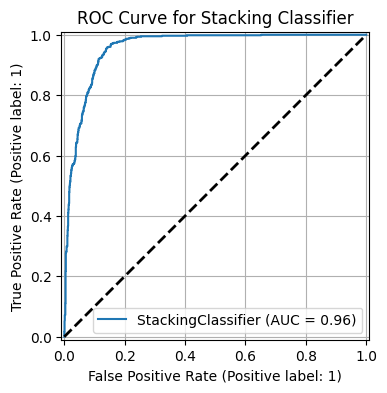


--- Summary of Model Performance ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Random Forest          0.8893     0.8109  0.8746    0.8415   0.9562
XGBoost                0.8898     0.7807  0.9348    0.8508   0.9539
Stacking Classifier    0.8954     0.7977  0.9231    0.8558   0.9573


In [45]:
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Stacking Classifier": stacking_model
}

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}") # Prioritized metric
    print(f"F1-Score: {f1:.4f}") # Prioritized metric
    print(f"ROC-AUC: {roc_auc:.4f}")

    results_df.loc[len(results_df)] = [name, accuracy, precision, recall, f1, roc_auc]

    # Display Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC Curve
    fig, ax = plt.subplots(figsize=(6, 4))
    roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    plt.title(f'ROC Curve for {name}')
    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random classifier line
    plt.grid(True)
    plt.show()

print("\n--- Summary of Model Performance ---")
print(results_df.set_index('Model').round(4))

## 8. Recommendation Engine
In parallel to the predictive classification system, a content-based recommendation engine was developed. This engine leverages the k-Nearest Neighbors (KNN) algorithm to identify similar successful apps. Note: The recommendation engine operates on already defined successful apps and does not predict the Success_Label itself, hence Rating and Installs are used here.

In [58]:
# The recommendation engine operates on already defined successful apps and does not predict the `Success_Label`.
# Therefore, features like `Rating`, `Installs`, and `Popularity_Index` are used as part of the similarity score.

# Create a DataFrame for recommendation from the preprocessed 'df'
df_rec_prep = df.copy()

# Ensure Installs, Rating, and other key features are numerical
# (This should have been done in preprocessing, but we re-verify for safety)
for col in ['Installs', 'Rating', 'Reviews', 'Size', 'Price', 'Days_Since_Last_Update', 'Popularity_Index']:
    if col in df_rec_prep.columns:
        df_rec_prep[col] = pd.to_numeric(df_rec_prep[col], errors='coerce')

# Re-create Success_Label to be certain
SUCCESS_INSTALLS_THRESHOLD = 1000000
SUCCESS_RATING_THRESHOLD = 4.2
df_rec_prep['Success_Label'] = ((df_rec_prep['Installs'] >= SUCCESS_INSTALLS_THRESHOLD) &
                                (df_rec_prep['Rating'] >= SUCCESS_RATING_THRESHOLD)).astype(int)

# Filter for successful apps only
successful_apps_for_rec = df_rec_prep[df_rec_prep['Success_Label'] == 1].copy()

# Select all relevant numerical and one-hot encoded features for similarity calculation
rec_features_list = [
    'Rating', 'Installs', 'Reviews', 'Size', 'Price', 'Monetization_Type',
    'Days_Since_Last_Update', 'Popularity_Index'
]

# Add all one-hot encoded Category and Genre columns
category_cols = [col for col in successful_apps_for_rec.columns if col.startswith('Category_')]
genre_cols = [col for col in successful_apps_for_rec.columns if col.startswith('Genre_')]
rec_features_list.extend(category_cols)
rec_features_list.extend(genre_cols)

# Ensure all selected features exist and handle any NaNs specific to this subset
final_rec_features = [col for col in rec_features_list if col in successful_apps_for_rec.columns]
X_rec = successful_apps_for_rec[final_rec_features].copy()
X_rec.fillna(X_rec.mean(), inplace=True)

# Scale all features for similarity calculation (important for distance metrics)
scaler_rec = MinMaxScaler()
X_rec_scaled = scaler_rec.fit_transform(X_rec)

print(f"Shape of successful apps data for recommendation: {X_rec_scaled.shape}")
print(f"Features used for recommendation: {X_rec.columns.tolist()}")
print("Sample of scaled features for recommendation:")
print(pd.DataFrame(X_rec_scaled, columns=X_rec.columns).head())

# Train KNN model on scaled data
k_neighbors = 5
knn_model = NearestNeighbors(n_neighbors=k_neighbors + 1, metric='euclidean')
knn_model.fit(X_rec_scaled)
print("KNN model trained for recommendations.")


Shape of successful apps data for recommendation: (2990, 94)
Features used for recommendation: ['Rating', 'Installs', 'Reviews', 'Size', 'Price', 'Monetization_Type', 'Days_Since_Last_Update', 'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME', 'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING', 'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY', 'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL', 'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL', 'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Genre_Personalizat

## 8.2. Generating Recommendations
The system computes similarity scores between an inputted app profile and the database of successful apps, retrieving the top-N closest ones.

In [61]:
def get_recommendations(app_name, successful_df, scaled_features, knn_model, rec_features, scaler):
    """
    Finds and recommends similar successful apps based on an app's name.

    Args:
        app_name (str): The name of the app to find recommendations for.
        successful_df (pd.DataFrame): DataFrame of successful apps (before scaling).
        scaled_features (np.array): Scaled feature array of successful apps.
        knn_model (NearestNeighbors): Trained KNN model.
        rec_features (list): List of feature column names used for scaling.
        scaler (MinMaxScaler): The scaler fitted on the recommendation features.
    """
    app_row = successful_df[successful_df['App'] == app_name]

    if app_row.empty:
        print(f"App '{app_name}' not found in the successful apps dataset.")
        return

    # Extract the features for the input app and reshape for scaling
    input_app_features = app_row[rec_features].values.reshape(1, -1)

    # Scale the input profile using the same scaler used for training KNN
    input_app_scaled = scaler.transform(input_app_features)

    # Find k+1 nearest neighbors (including itself)
    distances, indices = knn_model.kneighbors(input_app_scaled)

    print(f"\n--- Recommendations for '{app_name}' ---")
    recommended_apps = []
    # Loop through found neighbors (skip the first one as it's the input app itself)
    for i in range(1, len(distances.flatten())):
        idx = indices.flatten()[i]
        recommended_apps.append(successful_df.iloc[idx])

    if recommended_apps:
        rec_df = pd.DataFrame(recommended_apps)

        # FIX: Create a 'Category' column for display from the one-hot encoded columns
        rec_df['Category'] = rec_df.apply(
            lambda row: next((c.replace('Category_', '') for c in category_cols if row[c] == 1), 'N/A'),
            axis=1
        )

        cols_to_display = ['App', 'Category', 'Rating', 'Installs', 'Price']
        print("Top similar successful apps:")
        print(rec_df[cols_to_display])
    else:
        print("No similar successful apps found.")


# ==============================================================================
# Example Usage
# ==============================================================================
if not successful_apps_for_rec.empty:
    example_app_name = successful_apps_for_rec['App'].sample(1, random_state=42).iloc[0]

    get_recommendations(
        example_app_name,
        successful_apps_for_rec,
        X_rec_scaled,
        knn_model,
        final_rec_features,
        scaler_rec
    )
else:
    print("Not enough successful apps to demonstrate existing app recommendation.")


--- Recommendations for 'Samsung Max - Data Savings & Privacy Protection' ---
Top similar successful apps:
                                                  App Category  Rating    Installs  Price
3311                       Scientific Calculator Free    TOOLS     4.3   1000000.0    0.0
3330                         Google Handwriting Input    TOOLS     4.3  10000000.0    0.0
4590                                         T-Mobile    TOOLS     4.3  10000000.0    0.0
8909  DU Flashlight - Brightest LED & Flashlight Free    TOOLS     4.3   5000000.0    0.0
3294                                Flashlight HD LED    TOOLS     4.3  50000000.0    0.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [63]:
import joblib

print("--- Saving Model Components for Deployment ---")

# =================================================================================================
# 1. Save components for the PREDICTION MODEL
#    This allows us to load the model and predict the success label of a new app.
# =================================================================================================

# Save the final, trained Stacking Classifier model
joblib.dump(stacking_model, 'stacked_app_success_predictor.joblib')
print("Saved Stacking Classifier as 'stacked_app_success_predictor.joblib'")

# Save the exact list of feature names that the model was trained on.
# This ensures that any new data is passed to the model in the correct order.
# The 'X' DataFrame holds the features for the prediction model after all preprocessing.
joblib.dump(X.columns.tolist(), 'prediction_model_features.joblib')
print("Saved prediction model feature list as 'prediction_model_features.joblib'")


# =================================================================================================
# 2. Save components for the RECOMMENDATION ENGINE
#    This allows us to load the engine and find similar successful apps.
# =================================================================================================

# Save the trained KNN model
# 'knn_model' was trained in the recommendation section (8.1).
joblib.dump(knn_model, 'knn_recommendation_model.joblib')
print("Saved KNN model as 'knn_recommendation_model.joblib'")

# Save the specific scaler used for the recommendation features.
# 'scaler_rec' was the MinMaxScaler for the KNN features.
joblib.dump(scaler_rec, 'knn_features_scaler.joblib')
print("Saved KNN feature scaler as 'knn_features_scaler.joblib'")

# Save the list of feature names used to train the KNN model.
# 'final_rec_features' holds the exact list of features.
joblib.dump(final_rec_features, 'knn_model_features.joblib')
print("Saved KNN model feature list as 'knn_model_features.joblib'")

# Save the full DataFrame of successful apps.
# This is needed to map KNN indices back to full app details (name, category, etc.).
# Note: This file can be large. For a production system, you might save a smaller
# DataFrame with just the app ID and key details.
joblib.dump(successful_apps_for_rec, 'successful_apps_for_rec.joblib')
print("Saved successful apps DataFrame as 'successful_apps_for_rec.joblib'")

print("\nAll necessary model components have been saved successfully.")

--- Saving Model Components for Deployment ---
Saved Stacking Classifier as 'stacked_app_success_predictor.joblib'
Saved prediction model feature list as 'prediction_model_features.joblib'
Saved KNN model as 'knn_recommendation_model.joblib'
Saved KNN feature scaler as 'knn_features_scaler.joblib'
Saved KNN model feature list as 'knn_model_features.joblib'
Saved successful apps DataFrame as 'successful_apps_for_rec.joblib'

All necessary model components have been saved successfully.


## 9. System Deployment (Conceptual)
The final optimized Stacking Classifier, chosen for its superior generalization, is conceptually integrated into an interactive web-based application using Streamlit. While direct full deployment is typically handled outside a Colab Notebook, the following outlines its features.

- Real-time Prediction: User inputs app metadata, receives instant success likelihood.

- Visual Dashboard: Integrates SHAP (SHapley Additive exPlanations) or feature importance visualizations for interpretability (Lundberg & Lee, 2017).

- Success Likelihood Score: Outputs a probability-based classification result.

- Exploration of Similar Successful Apps: Recommends apps with similar attributes.

(Note for you: You might include a screenshot of your Streamlit app here if you have one, or a brief GIF showing its functionality.)

#10. Ethical Considerations and Limitations
Ethical considerations were embedded at each stage, focusing on data privacy, the system's role as a decision-support tool, and efforts to address potential biases. The study also acknowledges limitations such as its cross-sectional design, the specific definition of "success," potential data biases, and generalizability primarily to Android apps.

#11. Conclusion
This notebook has presented a practical walkthrough of the methodology employed to develop the Mobile App Success Prediction and Recommendation System. By following the structured approach of the Research Onion, we demonstrated the systematic procedures for data acquisition, preprocessing, feature engineering, ensemble model development (Random Forest, XGBoost, Stacking), and comprehensive evaluation. The integration of a recommendation engine further enhances the system's utility, providing actionable insights for investor decision-making in the dynamic mobile app ecosystem. The findings illustrate the potential of data-driven approaches to understand and predict success in this competitive market.